## Amazon Review Data : Data Exploration

### Setup spark

In [ ]:
# Import libraries
import os, pickle, glob
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, SQLContext, DataFrame
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.stat import Summarizer
from pyspark.ml.feature import Word2Vec, Tokenizer, StringIndexer, OneHotEncoder, PCA, VectorAssembler

In [ ]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "128g") \
	.config("spark.executor.memory", "64g") \
    .config('spark.executor.instances', 64) \
	.appName("Amazon Reviews") \
	.getOrCreate()


In [ ]:
sqlContext = SQLContext(sc)

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Read Data

### Get files

def get_df(files):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = None
    n = len(files)
    for i in range(n):
        data = read(get_path(files[i]))
        if df is None:
            df = data
        else:
            df = df.union(data)
    return df

# Data Preprocessing
* Finish major preprocessing, this includes scaling and/or transforming your data, imputing your data, encoding your data, feature expansion, Feature expansion (example is taking features and generating new features by transforming via polynomial, log multiplication of features).

In [ ]:
product_category_column = 'product_category'
review_body_column = 'review_body'
review_date_column = 'review_date'
title_column = 'product_title'
category_column = 'product_category'
product_parent_column = 'product_parent'
review_body_column = 'review_body'
verified_purchase_column = 'verified_purchase'

product_category_col = F.col(product_category_column)
review_body_col = F.col(review_body_column)
review_date_col = F.col(review_date_column)
title_col = F.col(title_column)
category_col = F.col(category_column)
product_parent_col = F.col(product_parent_column)
review_body_col = F.col(review_body_column)
verified_purchase_col = F.col(verified_purchase_column)

## Load Data & Take care of missing categories

In [ ]:
def get_imputed_df(files, category = True):
    """
    Method that combines files into 1 big df
    Takes in 1 parameter: list of file names
    """
    df = None
    n = len(files)
    categories = {}
    for i in range(n):
        data = read(get_path(files[i]))
        
        # Fill in null categories
        if category:
            cat = files[i][18:-10]
            categories[cat] = i
            data = data.withColumn(product_category_column,
                                   product_category_col).fillna(cat)
        
        if df is None:
            df = data
        else:
            df = df.union(data)
    return df, categories

## Get df & Remove Columns

In [ ]:
#df, categories = get_imputed_df(files)
df = df.drop('marketplace', 'vine')#.cache()

In [ ]:
sqlContext.registerDataFrameAsTable(df, "df")

In [ ]:
columns = df.columns
num_cols = len(columns)

## Filter out rows with missing body and date and verified purchase

In [ ]:
df = df.filter(review_body_col.isNotNull() & review_date_col.isNotNull())
df = df.filter(verified_purchase_col == True)

In [ ]:
df.head(1)

Out[12]: [Row(customer_id=53092436, review_id='RQ0ADUDW2U57V', product_id='0812550706', product_parent=401439625, product_title="Ender's Game (The Ender Quintet)", product_category='Books', star_rating='5', helpful_votes=0, total_votes=0, verified_purchase='Y', review_headline='HOW COULD ANYONE ONLY RATE THIS NOVEL A SIX?!?', review_body="Ender's Game is the most riveting and moving sf novel I  have ever read. For me, it was impossible to put down and never  rang a false note. The ending gave me goosebumps. I believe   that this book is the standard against   which all pure sf should be measured. (Fortunately I do not   write pure sf myself, but as a new  novelist I'm both awestruck and jealous of Orson Scott Card for having  written such an amazing story.)  James Halperin", review_date=datetime.date(1996, 10, 18))]

In [ ]:
# Select the review_date column
review_date_col = F.col('review_date')

# Find the minimum and maximum dates
min_max_dates = df.agg(F.min(review_date_col).alias('min_date'), 
                       F.max(review_date_col).alias('max_date'))

min_max_dates.show()

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|1995-11-09|2015-08-31|
+----------+----------+



## Filter out old data

In [ ]:
# Data before 2010 is more irrelevent to forcaste future trends. 
df = df.filter(F.year(review_date_col) >= 2010)
df.head(1)

Out[14]: [Row(customer_id=50704823, review_id='R2LF8CUPB3ESEX', product_id='0316069906', product_parent=656030315, product_title='Eating Animals', product_category='Books', star_rating='4', helpful_votes=158, total_votes=164, verified_purchase='Y', review_headline='To the point...', review_body='It is very hard to write a review of this book without expressing one\'s own view of the ethics of meat eating, as most of the reviews - and many of the comments to some of these reviews - demonstrate.  In fact, it is impossible to really separate the two when discussing a book that is both so personal in its narrative, and relentlessly focused on universal eating habits.  My review is no different.<br /><br />Taking a stab at the book itself:  I am not familiar with Foer\'s fictional works, but his background is evident as he lends the whole subject a compelling narrative and style that really make \\\\"Eating Animals\\\\" quite a page-turner (I read it in a day and a half).  To those familiar

## Check other missing values

In [ ]:
for i in range(num_cols):
    missing = df.filter(df[columns[i]].isNull()).count()
    print("'%s' column has %d missing values" % (columns[i], missing))

'customer_id' column has 0 missing values
'review_id' column has 0 missing values
'product_id' column has 0 missing values
'product_parent' column has 0 missing values
'product_title' column has 0 missing values
'product_category' column has 0 missing values
'star_rating' column has 0 missing values
'helpful_votes' column has 0 missing values
'total_votes' column has 0 missing values
'verified_purchase' column has 0 missing values
'review_headline' column has 36 missing values
'review_body' column has 0 missing values
'review_date' column has 0 missing values


* No more missing values

## Extract month and year

In [ ]:
month_column = 'month'
year_column = 'year'

In [ ]:
df = df.withColumn(month_column, F.month(review_date_col)).withColumn(year_column, F.year(review_date_col))
df.head(1)
subcategory_mapping = {
    'Major Appliances': 'Home Essentials',
    'Kitchen': 'Home Essentials',
    'Home Improvement': 'Home Essentials',
    'Tools': 'Home Essentials',
    'Home': 'Home Essentials',
    'Furniture': 'Home Essentials',
    'Office Products':'Home Essentials',
    
    'Outdoors': 'Outdoor Living',
    'Home Entertainment': 'Outdoor Living',
    'Lawn and Garden': 'Outdoor Living',
    
    'Video': 'Media',
    'Video DVD': 'Media',
    'Music': 'Media',
    'Books': 'Media',
    'Video Games': 'Media',
    'Software': 'Media',
    
    'Digital Music Purchase': 'Digital Media',
    'Digital Video Download': 'Digital Media',
    'Digital Ebook Purchase': 'Digital Media',
    'Digital Video Games': 'Digital Media',
    'Digital Software':'Digital Media',

    'Mobile Apps': 'Electronics',
    'Wireless': 'Electronics',
    'PC': 'Electronics',
    'Electronics': 'Electronics',
    'Mobile Electronics': 'Electronics',
    'Camera': 'Electronics',
    
    'Shoes': 'Apparel and Accessories',
    'Watches': 'Apparel and Accessories',
    'Luggage': 'Apparel and Accessories',
    'Apparel': 'Apparel and Accessories',
    
    'Health & Personal Care': 'Personal Care',
    'Beauty': 'Personal Care',
    'Personal Care Appliances': 'Personal Care',
    
    'Sports': 'Entertainment and Leisure',
    'Musical Instruments': 'Entertainment and Leisure',
    'Toys': 'Entertainment and Leisure',
    'Gift Card': 'Entertainment and Leisure',
    
    'Baby': 'Family and Living',
    'Automotive': 'Family and Living',
    'Grocery': 'Family and Living',
    'Pet Products': 'Family and Living',
}



In [ ]:
'''
from pyspark.sql.functions import year, month, col, date_format,count

# Assuming your DataFrame is called 'df'

# Filter the DataFrame for rows where the month is December and the year is 2014
df_dec_2014 = df.filter((year(df['review_date']) == 2014) & (month(df['review_date']) == 12))

# Count the number of rows
count_dec_2014 = df_dec_2014.count()

print("Count of review_date in December 2014:", count_dec_2014)
'''

Out[17]: '\nfrom pyspark.sql.functions import year, month, col, date_format,count\n\n# Assuming your DataFrame is called \'df\'\n\n# Filter the DataFrame for rows where the month is December and the year is 2014\ndf_dec_2014 = df.filter((year(df[\'review_date\']) == 2014) & (month(df[\'review_date\']) == 12))\n\n# Count the number of rows\ncount_dec_2014 = df_dec_2014.count()\n\nprint("Count of review_date in December 2014:", count_dec_2014)\n'

## Encode Categorical Columns

### Match category to numbers

In [ ]:
category_num_col = 'product_category_num'

In [ ]:
def translate(dic): 
    return F.udf(lambda x: dic.get(x), StringType()) 

In [ ]:
df = df.withColumn('product_category', translate(categories)(category_col))

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-4109292583323241> in <cell line: 1>()
----> 1 df = df.withColumn('product_category', translate(categories)(category_col))

NameError: name 'categories' is not defined

### Change title into vectors

In [ ]:
titleArray_column = 'titleArray'
titleVector_column = 'titleVector'

In [ ]:
df = df.withColumn(titleArray_column, F.split(F.lower(F.col(title_column)), ' '))

In [ ]:
word2vec = Word2Vec(inputCol = titleArray_column, outputCol = titleVector_column,
                    minCount = 100, vectorSize = 16, numPartitions = 4)
model = word2vec.fit(df)
df = model.transform(df)

### Change text into vectors

In [ ]:
reviewArray_column = 'reviewArray'
reviewVector_column = 'reviewVector'

In [ ]:
df = df.withColumn(reviewArray_column, F.split(F.lower(F.col(review_body_column)), ' '))

In [ ]:
word2vec = Word2Vec(inputCol = reviewArray_column, outputCol = reviewVector_column,
                    minCount = 100, vectorSize = 16, numPartitions = 4)
model = word2vec.fit(df)
df = model.transform(df)

In [ ]:
# remove stop words
# get the most repeated words 

In [ ]:
df.head(1)

Out[19]: [Row(customer_id=50704823, review_id='R2LF8CUPB3ESEX', product_id='0316069906', product_parent=656030315, product_title='Eating Animals', product_category='Books', star_rating='4', helpful_votes=158, total_votes=164, verified_purchase='Y', review_headline='To the point...', review_body='It is very hard to write a review of this book without expressing one\'s own view of the ethics of meat eating, as most of the reviews - and many of the comments to some of these reviews - demonstrate.  In fact, it is impossible to really separate the two when discussing a book that is both so personal in its narrative, and relentlessly focused on universal eating habits.  My review is no different.<br /><br />Taking a stab at the book itself:  I am not familiar with Foer\'s fictional works, but his background is evident as he lends the whole subject a compelling narrative and style that really make \\\\"Eating Animals\\\\" quite a page-turner (I read it in a day and a half).  To those familiar

## Dataset Splitting
* Use last year as test and the rest as train

In [ ]:
train = df.filter((F.year(review_date_col) >= 2010) & (F.year(review_date_col) < 2015))
test = df.filter(F.year(review_date_col) == 2015)

In [ ]:
print(train.count())
print(test.count())

56637188
27494572


## Count Product Reviews Per Day
* Group by unique product identifier and day to get reviews per day for each product

In [ ]:
grouped_df = df.groupby(review_date_col, product_parent_col).count()

In [ ]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

folder_path = ""
folder_size_bytes = get_folder_size(folder_path)
folder_size_kb = folder_size_bytes / 1024
folder_size_mb = folder_size_kb / 1024
folder_size_gb = folder_size_mb / 1024

print("Folder size:", folder_size_bytes, "bytes")
print("Folder size:", folder_size_kb, "KB")
print("Folder size:", folder_size_mb, "MB")
print("Folder size:", folder_size_gb, "GB")

# Data modeling
* Train your first model

In [ ]:
from pyspark.sql.functions import col, date_format,count
train_df= train.select(col('review_date'), col('product_category'))
train_df = train_df.withColumn("review_date", date_format(col("review_date"), "yyyy-MM"))
#train_df_1 = train_df.filter(year('review_date') == 2014)
train_df.show(10)

+-----------+----------------+
|review_date|product_category|
+-----------+----------------+
|    2010-01|           Books|
|    2010-01|       Video DVD|
|    2010-01|           Books|
|    2010-01|       Video DVD|
|    2010-01|       Video DVD|
|    2010-01|              PC|
|    2010-01|           Books|
|    2010-01|       Video DVD|
|    2010-01|           Books|
|    2010-01|           Books|
+-----------+----------------+
only showing top 10 rows



In [ ]:
train_df = train_df.na.drop() # there were null in product_category_num column
train_df.show()
distinct_product_category_num = train_df.select("product_category").distinct()
distinct_product_category_num.show(35)

+-----------+--------------------+
|review_date|    product_category|
+-----------+--------------------+
|    2010-01|               Books|
|    2010-01|           Video DVD|
|    2010-01|               Books|
|    2010-01|           Video DVD|
|    2010-01|           Video DVD|
|    2010-01|                  PC|
|    2010-01|               Books|
|    2010-01|           Video DVD|
|    2010-01|               Books|
|    2010-01|               Books|
|    2010-01|               Music|
|    2010-01|Digital_Music_Pur...|
|    2010-01|Digital_Video_Dow...|
|    2010-01|           Video DVD|
|    2010-01|               Music|
|    2010-01|           Video DVD|
|    2010-01|Digital_Ebook_Pur...|
|    2010-01|           Video DVD|
|    2010-01|               Books|
|    2010-01|         Video Games|
+-----------+--------------------+
only showing top 20 rows

+--------------------+
|    product_category|
+--------------------+
|                  PC|
|     Lawn and Garden|
|             Kitch

In [ ]:
# Group by 'year', 'month', and 'product_category_num' and count occurrences
train_df = train_df.withColumn("year", year("review_date"))
train_df = train_df.withColumn("month", month("review_date"))

#count_per_month = train_df.groupBy("year", "month", "product_category").agg(count("*").alias("count"))
#count_per_month.show()

<Figure size 864x432 with 0 Axes>

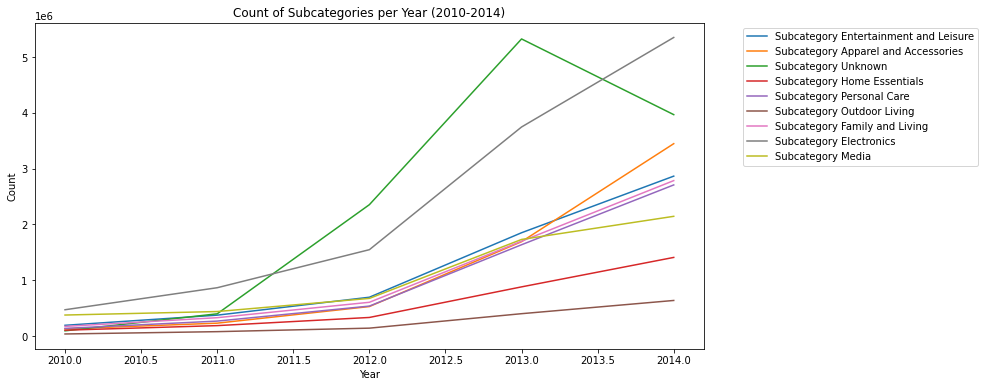

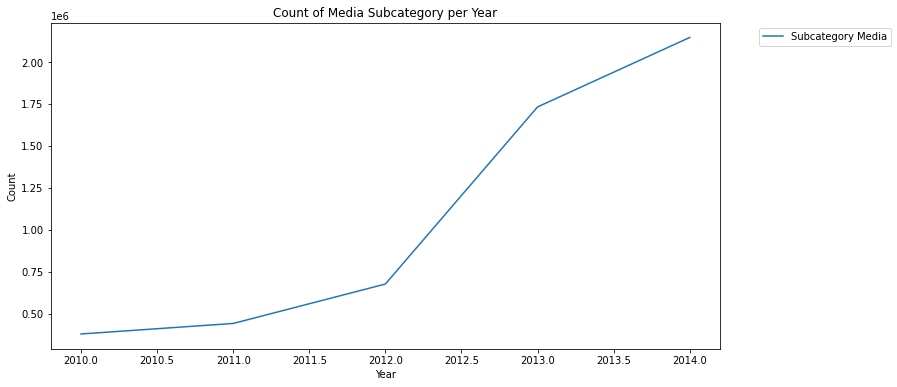

In [ ]:
broadcast_mapping = spark.sparkContext.broadcast(subcategory_mapping)


def get_subcategory(product_category):
    return broadcast_mapping.value.get(product_category, 'Unknown')

subcategory_udf = udf(get_subcategory, StringType())

train_df = train_df.withColumn('subcategory', subcategory_udf(col('product_category')))
count_per_month = train_df.groupBy("year", "month", "subcategory").agg(count("*").alias("count"))




df_pd = count_per_month.toPandas()

plt.figure(figsize=(12, 6))

# Loop product categories num and plot counts with different colors

'''for category in df_pd['product_category'].unique():
    df_cat = df_pd[df_pd['product_category'] == category]
    df_cat = df_cat.sort_values(by='year')
    plt.plot(df_cat['year'], df_cat['count'], label=f'Product Category {category}')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Product Categories per Years 2010-2014')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()'''

plt.figure(figsize=(12, 6))

for subcategory in df_pd['subcategory'].unique():
    df_subcat = df_pd[df_pd['subcategory'] == subcategory]
    df_subcat = df_subcat.sort_values(by='year')
    df_subcat = df_subcat.groupby('year')['count'].sum().reset_index()
    plt.plot(df_subcat['year'], df_subcat['count'], label=f'Subcategory {subcategory}')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Subcategories per Year (2010-2014)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


df_media = df_pd[df_pd['subcategory'] == 'Media']

df_media_grouped = df_media.groupby('year')['count'].sum().reset_index()
df_media_grouped = df_media_grouped.sort_values(by='year')
plt.figure(figsize=(12, 6))
plt.plot(df_media_grouped['year'], df_media_grouped['count'], label='Subcategory Media')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Media Subcategory per Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
from pyspark.sql.functions import year, month, count as spark_count

#train_df_2 = train_df.filter(col('product_category_num') == 32)
#train_df_2 = train_df_2.withColumn("year", year("review_date"))
#train_df_2 = train_df_2.withColumn("month", month("review_date"))

# Group by 'year', 'month', and 'product_category_num' and count occurrences
#count_per_month = train_df.groupBy("year", "month").agg(spark_count("*").alias("count"))
#count_per_month.show()

#6-> 13649
#20 -> 611329

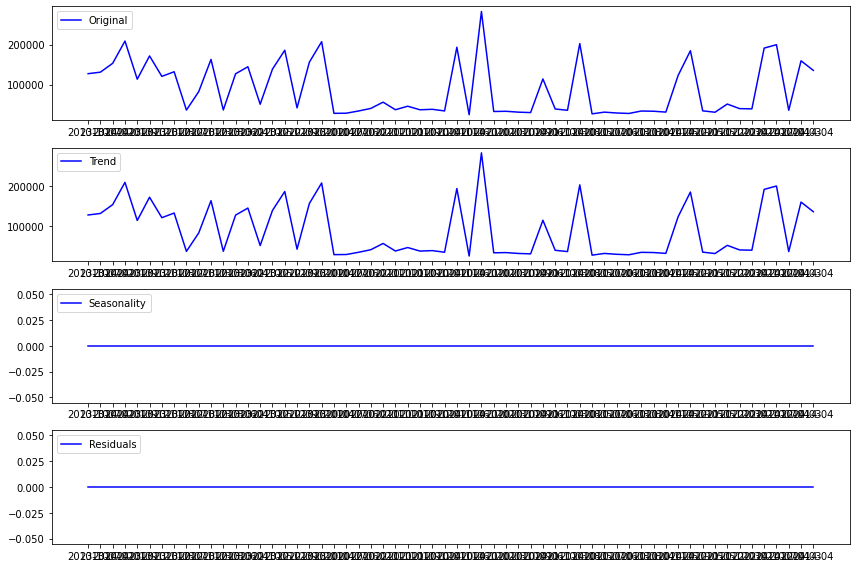

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


count_per_month2 = train_df.groupBy("review_date", "subcategory").agg(count("*").alias("count"))
df_pd2 = count_per_month2.toPandas()


df_pd2 = df_pd2[df_pd2['subcategory'] == 'Media']
df_pd2.set_index('review_date', inplace=True)
count_series = df_pd2['count']

result = seasonal_decompose(count_series, model='additive', period=30)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result.observed, label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality', color='blue')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(result.resid, label='Residuals', color='blue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<command-4109292583323264>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!EcsLrov1j6Sv5QU2ls1MURvok6NnnsMi7CoITQL0dSp5QhXS_1yH96ZjCUjue55bsx3L3kUlzz3SPw6oEZdvf4lzFxqJ9g$   df_media['date'] = pd.to_datetime(df_media[['year', 'month']].assign(day=1))
/databricks/python/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html*returning-a-view-versus-a-copy*5Cn__;IyU!!Mih3wA!EcsLrov1j6Sv5QU2ls1MURvok6NnnsMi7CoITQL0dSp5QhXS_1yH96ZjCUjue55bsx3L3kUlzz3SPw6oEZdvf4lzFxqJ9g$   return 

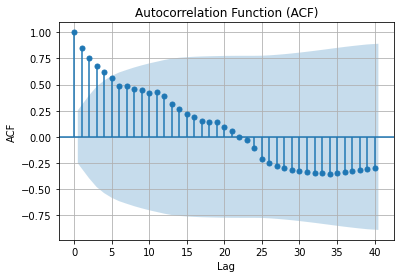

<Figure size 864x432 with 0 Axes>

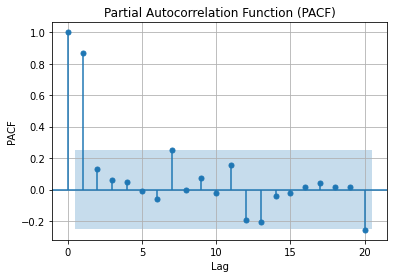

Forecast: 60    278800.106881
61    266152.191136
62    257709.895972
63    250177.378503
64    255173.087515
65    252335.568888
66    253947.254425
67    253031.831264
Name: predicted_mean, dtype: float64
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/ts

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df_media['date'] = pd.to_datetime(df_media[['year', 'month']].assign(day=1))
df_media.sort_values(by='date', inplace=True)


series = df_media.set_index('date')['count']

plt.figure(figsize=(12, 6))
plot_acf(series, lags=40, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(series, lags=20, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()


# Extract the time series data
series = df_media['count']

# Fit ARIMA model p,d,q
model = ARIMA(series, order=(1, 1, 5))  
model_fit = model.fit()

# 2015 Predictions 
forecast_steps = 8
forecast = model_fit.forecast(steps=forecast_steps) 
print("Forecast:", forecast)



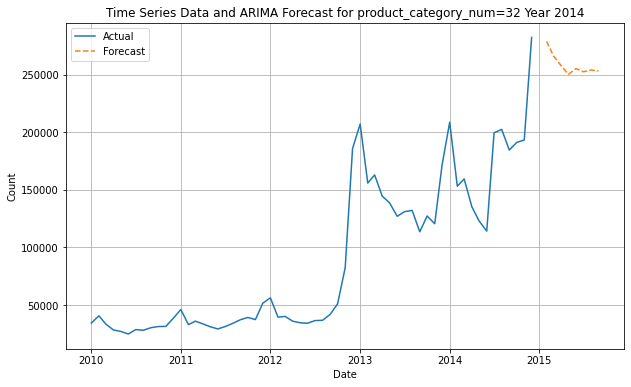

In [ ]:
# time series data plot
plt.figure(figsize=(10, 6))
plt.plot(df_media['date'], df_media['count'], label='Actual')

# Plot the forecast
forecast_dates = pd.date_range(start=df_media['date'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Time Series Data and ARIMA Forecast for product_category_num=32 Year 2014')
plt.legend()

plt.grid(True)
plt.show()

# Data Evaluation
* Evaluate your model and compare training vs. test error

In [ ]:
test_df_filter = test.filter(col('product_category').isin('Video DVD', 'Music', 'Books', 'Video Games'))
test_df_filter= test_df_filter.select(col('review_date'), col('product_category'))
test_df_filter = test_df_filter.withColumn("review_date", date_format(col("review_date"), "yyyy-MM"))
test_df_filter = test_df_filter.withColumn("year", year("review_date"))
test_df_filter = test_df_filter.withColumn("month", month("review_date"))
#test_df_1 = test_df.filter((col('product_category') == 32))
test_df_filter.show(3)


+-----------+----------------+----+-----+
|review_date|product_category|year|month|
+-----------+----------------+----+-----+
|    2015-01|       Video DVD|2015|    1|
|    2015-01|           Music|2015|    1|
|    2015-01|       Video DVD|2015|    1|
+-----------+----------------+----+-----+
only showing top 3 rows



In [ ]:
# Group by 'year', 'month', and 'product_category_num' and count occurrences
test_count_per_month = test_df_filter.groupBy("year", "month").agg(spark_count("*").alias("count"))

test_count_per_month.show()

+----+-----+------+
|year|month| count|
+----+-----+------+
|2015|    1|302651|
|2015|    4|218992|
|2015|    8|195389|
|2015|    7|198534|
|2015|    6|194788|
|2015|    5|202099|
|2015|    2|263181|
|2015|    3|265484|
+----+-----+------+



In [ ]:
test_count_per_month_pd = test_count_per_month.toPandas()
test_count_per_month_pd['date'] = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
test_count_per_month_pd.sort_values(by='date', inplace=True)

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

test_values = test_count_per_month.select('count').rdd.flatMap(lambda x: x).collect()
rmse = sqrt(mean_squared_error(test_values, forecast))
print('Test RMSE:', rmse)
# this is how off we predicted the actualy values. 

Test RMSE: 47529.12780238352


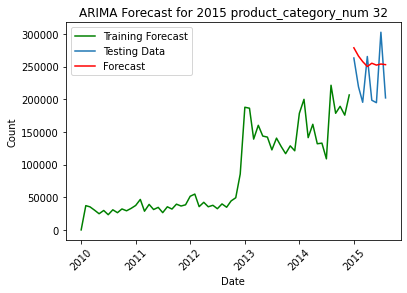

In [ ]:
# Plot forecast, training, and testing data
plt.plot(df_media['date'], model_fit.fittedvalues, color='green', label='Training Forecast')

test_dates = pd.to_datetime(test_count_per_month_pd[['year', 'month']].assign(day=1))
plt.plot(test_dates, test_values, label='Testing Data')

# Plot forecast
plt.plot(test_dates, forecast, color='red', label='Forecast')

plt.title('ARIMA Forecast for 2015 product_category_num 32')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

### Fitting Graph

In [ ]:
count_per_month2 = count_per_month.filter((col('subcategory') == 'Media'))
train_values = count_per_month2.select('count').rdd.flatMap(lambda x: x).collect()

test_errors = []
train_errors = []
i_values = list(range(1, 20))

for i in i_values:
    model = ARIMA(series, order=(1, 1+i, 5))
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=forecast_steps)
    train_rmse = sqrt(mean_squared_error(train_values, model_fit.fittedvalues))
    train_errors.append(train_rmse)
    
    test_rmse = sqrt(mean_squared_error(test_values, forecast))
    test_errors.append(test_rmse)

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/databricks/python/lib/python3.9/site-p

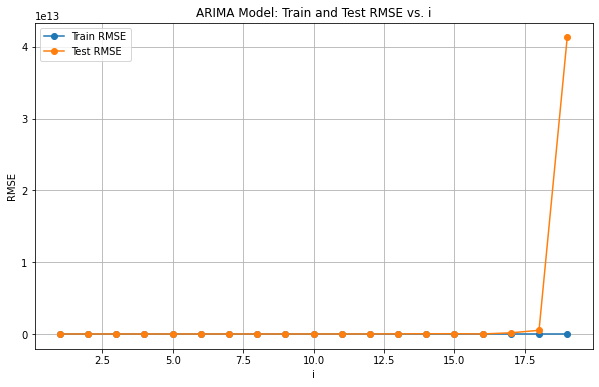

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(i_values, train_errors, label='Train RMSE', marker='o')
plt.plot(i_values, test_errors, label='Test RMSE', marker='o')
plt.xlabel('i')
plt.ylabel('RMSE')
plt.title('ARIMA Model: Train and Test RMSE vs. i')
plt.legend()
plt.grid(True)
plt.show()

# Answer the questions
* Where does your model fit in the fitting graph? and What are the next models you are thinking of and why?

Based on the ARIMA model for product_category_num 32 of the year 2014, we forcasted the estimate of sales (with assumption based on reviews). The next models will include more training data, prior to 2014 for all product catgeories. We may possibily utilize the word2vector data to see the primary key words that have the highest count of reviews which we assume correlates to high counts of purchases. Through this we can forcast what speciifc item or product_category_num will increase in sales. However before moving on to more complicated models, our team will focus on building upon the ARIMA model to more acurately forcast which product_category_num is rise in sales/popular as the forcasted and test data concluded with a RMSE of 28498.15662477966. 

# Conclusion section
* What is the conclusion of your 1st model? What can be done to possibly improve it?

The 1st model concluded with an RMSE of 28498.156. This isn't the best given that there is almost a difference of 30k of the forcsted and the actualy 2015 test data for the product_category_num 32. We can increase the training data from 2014 to the range of 2010 to 2014. We do this for all the product_category_num to be able to accurately predict which item is more popular.  By increasing the training data we will be able to catch more underlying patterns thorughout the years. 